$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bb}[1]{\boldsymbol{#1}}
$$

# CS236781: Deep Learning
# Tutorial 6: Sequence Models

## Introduction

In this tutorial, we will cover:

- What RNNs are and how they work
- Implementing basic RNNs models
- Application example: sentiment analysis of movie reviews
- Temporal Convolution Networks as an RNN alternative

In [1]:
# Setup
%matplotlib inline
import os
import sys
import time
import torch
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter("ignore")

In [2]:
plt.rcParams['font.size'] = 20
data_dir = os.path.expanduser('~/.pytorch-datasets')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Theory Reminders

Thus far, our models have been composed of fully connected (linear) layers or convolutional layers.

- Fully connected layers
    - Each layer $l$ operates on the output of the previous layer ($\vec{y}_{l-1}$) and calculates,
        $$
        \vec{y}_l = \varphi\left( \mat{W}_l \vec{y}_{l-1} + \vec{b}_l \right),~
        \mat{W}_l\in\set{R}^{n_{l}\times n_{l-1}},~ \vec{b}_l\in\set{R}^{n_l}.
        $$
    - FC's have completely pre-fixed input and output dimensions.
    
    <center><img src="img/mlp.png" width="600" /></center>

- Convolutional layers
    - Each layer operates on an input tensor $\vec{x}$ containing $M$ feature maps. The $k$-th feature map of the output tensor $\vec{y}$ is:
        $$
        \vec{y}^k = \sum_{m=1}^{M} \vec{w}^{km}\ast\vec{x}^m+b^k,\ k\in[1,K]
        $$
      Where $\ast$ denotes convolution, and $K$ is the number of output feature maps.
      
      <center><img src="img/cnn_filters.png" width="500"/></center>
      
    - This time the weight dimensions are not dependent on the input dimensions.
    - Weights are shared across the spatial dimensions of the input.
    - Output dimension changes based on input dimension.


However,
- Models based on these types of layers lack **persistent state**. 
- The current output is not affected by **previous inputs** (or outputs).

How can we model a dynamical system?
E.g., a linear system such as

$$\vec{y}_t = a_0 + a_1 \vec{y}_{t-1}+\dots+a_P \vec{y}_{t-P} + b_0 \vec{x}_t+\dots+b_{t-Q}\vec{x}_{t-Q}$$

Many use cases and examples: text translation, sentiment analysis, scene classification in video, etc.

## Recurrent layers

An RNN layer is similar to a regular FC layer, but it has two inputs:
- Current sample, $\vec{x}_t \in\set{R}^{d_{i}}$.
- Previous **state**, $\vec{h}_{t-1}\in\set{r}^{d_{h}}$.

and it produces two outputs which depend on both:
- Current layer output, $\vec{y}_t\in\set{R}^{d_o}$.
- Current **state**, $\vec{h}_{t}\in\set{r}^{d_{h}}$.

<center><img src="img/rnn_cell.png" width="400"/></center>

Crucially,
- The function $\varphi(\cdot)$ itself is not time-dependent (but is parametrized).
- The same layer (function) is applied at successive time steps, propagating the hidden state.

A basic RNN can be defined as follows.

$$
\begin{align}
\forall t \geq 0:\\
\vec{h}_t &= \varphi_h\left( \mat{W}_{hh} \vec{h}_{t-1} + \mat{W}_{xh} \vec{x}_t + \vec{b}_h\right) \\
\vec{y}_t &= \varphi_y\left(\mat{W}_{hy}\vec{h}_t + \vec{b}_y \right)
\end{align}
$$

where,
- $\vec{x}_t \in\set{R}^{d_{i}}$ is the input at time $t$.
- $\vec{h}_{t-1}\in\set{R}^{d_{h}}$ is the **hidden state** of a fixed dimension.
- $\vec{y}_t\in\set{R}^{d_o}$ is the output at time $t$.
- $\mat{W}_{hh}\in\set{R}^{d_h\times d_h}$, $\mat{W}_{xh}\in\set{R}^{d_h\times d_i}$, $\mat{W}_{hy}\in\set{R}^{d_o\times d_h}$, $\vec{b}_h\in\set{R}^{d_h}$ and $\vec{b}_y\in\set{R}^{d_o}$ are the model weights and biases.
- $\varphi_h$ and $\varphi_y$ are some non-linear functions. In many cases $\varphi_y$ is not used.

### Modeling time-dependence

If we imagine **unrolling** a single RNN layer through time,
<center><img src="img/rnn_unrolled.png" width="1200" /></center>

We can see how late outputs can now be influenced by early inputs, through the hidden state.

RNN models are very flexible in terms of input and output meaning.

Common applications include image captioning, sentiment analysis, machine translation and more. 

<center><img src="img/rnn_use_cases.jpeg" width="1200"/></center>


How would **backpropagation** work, though?

<center><img src="img/bptt.png" width="1000"></center>

1. Calculated loss from each output and accumulate
2. Calculate Gradient of loss w.r.t. each parameter at each timestep
3. For each parameter, accumulate gradients from all timesteps

This is known as **Backpropagation through time**, or BPTT.

$$
\pderiv{L_t}{\mat{W}} = \sum_{k=1}^{t}
\pderiv{L_t}{\hat y_t} \cdot
\pderiv{\hat y_t}{\vec{h}_t} \cdot
\pderiv{\vec{h}_t}{\vec{h}_k} \cdot
\pderiv{\vec{h}_k}{\mat{W}}
$$

But how far back do we go? What's the limiting factor?

We're limited in depth by vanishing and exploding gradients controlled by the eigenvalues of $\mat{W}$.

One pragmatic solution is to limit the number of timesteps involved in the backpropagation.

<center><img src="img/tbptt.png" width="1000"></center>

This is known as **Truncated backpropagation through time**, or TBPTT.

### Multi-layered (deep) RNN

RNNs layers can be stacked to build a deep RNN model.

<center><img src="img/rnn_layered.png" width="1200"/></center>

- As with MLPs, adding depth allows us to model intricate hierarchical features.
- However, now we also have a time dimension which makes the representation time-dependent.

## RNN Implementation

Based on the above equations, let's create a simple RNN layer  with PyTorch.

In [3]:
import torch.nn as nn

class RNNLayer(nn.Module):
    def __init__(self, in_dim, h_dim, out_dim, phi_h=torch.tanh, phi_y=torch.sigmoid):
        super().__init__()
        self.phi_h, self.phi_y = phi_h, phi_y
        
        self.fc_xh = nn.Linear(in_dim, h_dim, bias=False)
        self.fc_hh = nn.Linear(h_dim, h_dim, bias=True)
        self.fc_hy = nn.Linear(h_dim, out_dim, bias=True)
        
    def forward(self, xt, h_prev=None):
        if h_prev is None:
            h_prev = torch.zeros(xt.shape[0], self.fc_hh.in_features)
        
        ht = self.phi_h(self.fc_xh(xt) + self.fc_hh(h_prev))
        
        yt = self.fc_hy(ht)
        
        if self.phi_y is not None:
            yt = self.phi_y(yt)
        
        return yt, ht
        

We'll instantiate our model

In [4]:
N = 3 # batch size
in_dim, h_dim, out_dim = 1024, 10, 1

rnn = RNNLayer(in_dim, h_dim, out_dim)
rnn

RNNLayer(
  (fc_xh): Linear(in_features=1024, out_features=10, bias=False)
  (fc_hh): Linear(in_features=10, out_features=10, bias=True)
  (fc_hy): Linear(in_features=10, out_features=1, bias=True)
)

And manually "run" a few time steps

In [5]:
# t=1
x1 = torch.randn(N, in_dim, requires_grad=True) # requiring grad just for torchviz
y1, h1 = rnn(x1)
print(f'y1 ({tuple(y1.shape)}):\n{y1}')
print(f'h1 ({tuple(h1.shape)}):\n{h1}\n')

# t=2
x2 = torch.randn(N, in_dim, requires_grad=True)
y2, h2 = rnn(x2, h1)
print(f'y2 ({tuple(y2.shape)}):\n{y2}')
print(f'h2 ({tuple(h2.shape)}):\n{h2}\n')

y1 ((3, 1)):
tensor([[0.6092],
        [0.4527],
        [0.5641]], grad_fn=<SigmoidBackward>)
h1 ((3, 10)):
tensor([[-0.3253,  0.1187,  0.4649,  0.7870, -0.6650, -0.5900, -0.3890, -0.2207,
         -0.0210, -0.1011],
        [ 0.1354, -0.4635, -0.2131,  0.5795,  0.5590,  0.0958,  0.4714,  0.6022,
          0.6905,  0.8131],
        [-0.1787, -0.5957, -0.1554,  0.6158,  0.3674,  0.7465, -0.1909, -0.6615,
         -0.2385,  0.1083]], grad_fn=<TanhBackward>)

y2 ((3, 1)):
tensor([[0.5789],
        [0.5941],
        [0.4519]], grad_fn=<SigmoidBackward>)
h2 ((3, 10)):
tensor([[ 0.5649,  0.6421, -0.6361,  0.6028,  0.2501, -0.1958, -0.7198, -0.0052,
          0.6093, -0.9005],
        [ 0.2390, -0.7378, -0.0780,  0.9072, -0.4775,  0.6405,  0.5359, -0.2134,
          0.5885, -0.5422],
        [ 0.1098,  0.5624,  0.0769,  0.2086,  0.7552,  0.2479, -0.2085, -0.2261,
         -0.0115,  0.4094]], grad_fn=<TanhBackward>)



As usual, let's visualize the computation graph and see what happened when we used the same RNN block twice, by looking at the graph from both $y_1$ and $y_2$.

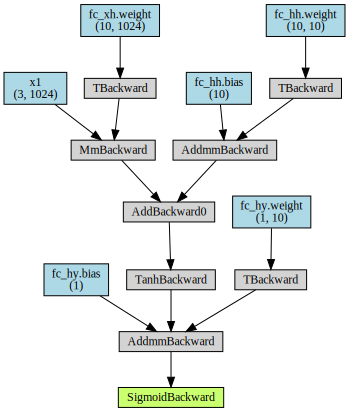

In [6]:
import torchviz

torchviz.make_dot(
    y1, # Note: Change here to y1 to see the fullly unrolled graph!
    params=dict(list(rnn.named_parameters()) + [('x1', x1), ('x2', x2)])
)

## Part 1: Sentiment analysis for movie reviews

The task: Given a review about a movie written by some user, decide whether it's **positive**, **negative** or **neutral**.

<center><img src="img/sentiment_analysis.png" width="500" /></center>


Classically this is considered a challenging task if approached based on keywords alone.

Consider:

     "This movie was actually neither that funny, nor super witty."
     
To comprehend such a sentence, it's intuitive to see that some "state" must be kept when "reading" it.

### Dataset

We'll use the [`torchtext`](https://github.com/pytorch/text) package, which provides useful tools for working ith textual data, and also includes some built-in datasets and dataloaders (similar to `torchvision`).

Out dataset will be the [Stanford Sentiment Treebank](https://nlp.stanford.edu/sentiment/treebank.html) (SST) dataset, which contains ~10,000 **labeled** movie reviews.

The label of each review is either "positive", "neutral" or "negative".


#### Loading and tokenizing text samples

The `torchtext.data.Field` class takes care of splitting text into unique "tokens"
(~words) and converting it a numerical representation as a sequence of numbers representing
the tokens in the text.

In [7]:
import torchtext.data

# torchtext Field objects parse text (e.g. a review) and create a tensor representation

# This Field object will be used for tokenizing the movie reviews text
review_parser = torchtext.data.Field(
    sequential=True, use_vocab=True, lower=True,
    init_token='<sos>', eos_token='<eos>', dtype=torch.long,
    tokenize='spacy', tokenizer_language='en_core_web_sm'
)

# This Field object converts the text labels into numeric values (0,1,2)
label_parser = torchtext.data.Field(
    is_target=True, sequential=False, unk_token=None, use_vocab=True
)

In [8]:
import torchtext.datasets

# Load SST, tokenize the samples and labels
# ds_X are Dataset objects which will use the parsers to return tensors
ds_train, ds_valid, ds_test = torchtext.datasets.SST.splits(
    review_parser, label_parser, root=data_dir
)

n_train = len(ds_train)
print(f'Number of training samples: {n_train}')
print(f'Number of test     samples: {len(ds_test)}')

Number of training samples: 8544
Number of test     samples: 2210


Lets print some examples from our training data:

In [9]:
for i in ([111, 4321, 7777, 0]):
    example = ds_train[i]
    label = example.label
    review = str.join(" ", example.text)
    print(f'sample#{i:04d} [{label:8s}]:\n > {review}\n')

sample#0111 [positive]:
 > the film aims to be funny , uplifting and moving , sometimes all at once .

sample#4321 [neutral ]:
 > the most anti - human big studio picture since 3000 miles to graceland .

sample#7777 [negative]:
 > an ugly , revolting movie .

sample#0000 [positive]:
 > the rock is destined to be the 21st century 's new ` ` conan '' and that he 's going to make a splash even greater than arnold schwarzenegger , jean - claud van damme or steven segal .



#### Building a vocabulary

The `Field` object can build a **vocabulary** for us,
which is simply a bi-directional mapping between a unique index and a token.

We'll only include words from the training set in our vocabulary.

In [10]:
review_parser.build_vocab(ds_train)
label_parser.build_vocab(ds_train)

print(f"Number of tokens in training samples: {len(review_parser.vocab)}")
print(f"Number of tokens in training labels: {len(label_parser.vocab)}")

Number of tokens in training samples: 15482
Number of tokens in training labels: 3


In [11]:
print(f'first 20 tokens:\n', review_parser.vocab.itos[:20], end='\n\n')

first 20 tokens:
 ['<unk>', '<pad>', '<sos>', '<eos>', '.', 'the', ',', 'a', 'and', 'of', 'to', '-', 'is', "'s", 'it', 'that', 'in', 'as', 'but', 'film']



Note the **special tokens**, `<unk>`, `<pad>`, `<sos>` and `<eos>` at indexes `0-3`.
These were automatically created by the tokenizer.

In [12]:
# Show that some words exist in the vocab
for w in ['film', 'actor', 'schwarzenegger', 'spielberg']:
    print(f'word={w:15s} index={review_parser.vocab.stoi[w]}')

word=film            index=19
word=actor           index=492
word=schwarzenegger  index=3404
word=spielberg       index=715


In [13]:
print(f'labels vocab:\n', dict(label_parser.vocab.stoi))

labels vocab:
 {'positive': 0, 'negative': 1, 'neutral': 2}


#### Data loaders (iterators)

The `torchtext` package comes with `Iterator`s, similar to the `DataLoaders` we previously worked with.

A key issue when working with text sequences is that each sample is of a different length.

So, how can we work with **batches** of data?

In [14]:
BATCH_SIZE = 4

# BucketIterator creates batches with samples of similar length
# to minimize the number of <pad> tokens in the batch.
dl_train, dl_valid, dl_test = torchtext.data.BucketIterator.splits(
    (ds_train, ds_valid, ds_test), batch_size=BATCH_SIZE,
    shuffle=True, device=device)

Lets look at a single batch.

In [15]:
batch = next(iter(dl_train))

X, y = batch.text, batch.label
print('X = \n', X, X.shape, end='\n\n')
print('y = \n', y, y.shape)

X = 
 tensor([[    2,     2,     2,     2],
        [    5,  2510, 14117,    14],
        [ 1677,   378,    67,    13],
        [  742,    28,    66,    32],
        [  137,  1306,   852,   349],
        [   31,   930,  7505,    17],
        [  275,    21,    10,   429],
        [    5,   484,    25,    51],
        [   22,  4637,  1353,   356],
        [   43,     6,     6,    17],
        [  155,    18,  8051,    25],
        [ 4154,    14,    55,  1557],
        [    5,    95,  4313,     6],
        [  289,  1353, 14288,    18],
        [ 4890,   654,    39,    57],
        [   14,     7,    27,    40],
        [ 1890,   179,   782,    97],
        [ 3751,  7764,    35,   252],
        [    4,   419,     8,   930],
        [    3,    41,    27,    10],
        [    1,     7,  1151,   275],
        [    1,  1729,    35,    23],
        [    1,     9,     8,    43],
        [    1,    25,    44,   140],
        [    1,  6441,    15,     7],
        [    1,     4, 12122,  1026],
      

What are we looking at?

Our sample tensor `X` is of shape `(sentence_length, batch_size)`.

Note that:
1. `sentence_length` changes every batch! You can re-run the previous block to see this.
2. Sequence dimension first (not batch). When we implement the model, you'll see why it's easier to work this way.

### Model

We'll now create our sentiment analysis model based on the simple `RNNLayer` we've implemented above.

The model will:
- Take an input batch of tokenized sentences.
- Compute a dense word-embedding of each token.
- Process the sentence **sequentially** through the RNN layer.
- Produce a `(B, 3)` tensor, which we'll interpret as class probabilities for each sentence in the batch.

What is a **word embedding**? How do we get one?

Embeddings encode tokens as tensors in a way that maintain some **semantic** meaning for our task.

<center><img src="img/word_embeddings.png" width="700"/></center>

Generally we should take a pre-trained embedding depending on our task type.

Here we'll train an Embedding together with our model:

In [16]:
embedding_layer = nn.Embedding(num_embeddings=5, embedding_dim=8)

token_idx = torch.randint(low=0, high=5, size=(6,))
print(token_idx)
embedding_layer(token_idx)

tensor([4, 3, 3, 3, 3, 0])


tensor([[ 0.4597,  0.2945, -1.1264, -1.3419,  0.4035,  0.9961,  0.2710,  1.6505],
        [-2.1591, -1.4564,  1.7908,  0.0338,  0.0664,  0.3454, -1.2780,  0.7022],
        [-2.1591, -1.4564,  1.7908,  0.0338,  0.0664,  0.3454, -1.2780,  0.7022],
        [-2.1591, -1.4564,  1.7908,  0.0338,  0.0664,  0.3454, -1.2780,  0.7022],
        [-2.1591, -1.4564,  1.7908,  0.0338,  0.0664,  0.3454, -1.2780,  0.7022],
        [ 0.6942,  2.5393, -1.0735, -1.1092,  0.3154,  1.8286, -2.2860,  0.2483]],
       grad_fn=<EmbeddingBackward>)

OK, model time:

In [17]:
class SentimentRNN(nn.Module):
    def __init__(self, vocab_dim, embedding_dim, h_dim, out_dim):
        super().__init__()
        
        # nn.Embedding converts from token index to dense tensor
        self.embedding = nn.Embedding(vocab_dim, embedding_dim)
        
        # Our own Vanilla RNN layer, without phi_y so it outputs a class score
        self.rnn = RNNLayer(in_dim=embedding_dim, h_dim=h_dim, out_dim=out_dim, phi_y=None)
        
        # To convert class scores to log-probability we'll apply log-softmax
        self.log_softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, X):
        # X shape: (S, B) Note batch dim is not first!
        
        embedded = self.embedding(X) # embedded shape: (S, B, E)
        
        # Loop over (batch of) tokens in the sentence(s)
        ht = None
        for xt in embedded:           # xt is (B, E)
            yt, ht = self.rnn(xt, ht) # yt is (B, D_out)
        
        # Class scores to log-probability
        yt_log_proba = self.log_softmax(yt)
        
        return yt_log_proba

Let's instantiate our model.

In [18]:
INPUT_DIM = len(review_parser.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 128
OUTPUT_DIM = 3

model = SentimentRNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)
model

SentimentRNN(
  (embedding): Embedding(15482, 100)
  (rnn): RNNLayer(
    (fc_xh): Linear(in_features=100, out_features=128, bias=False)
    (fc_hh): Linear(in_features=128, out_features=128, bias=True)
    (fc_hy): Linear(in_features=128, out_features=3, bias=True)
  )
  (log_softmax): LogSoftmax(dim=1)
)

Test a manual forward pass:

In [19]:
print(f'model(X) = \n', model(X), model(X).shape)
print(f'labels = ', y)

model(X) = 
 tensor([[-1.2143, -1.0999, -0.9938],
        [-1.2143, -1.0999, -0.9938],
        [-1.1641, -1.3582, -0.8424],
        [-1.2143, -1.0999, -0.9938]], grad_fn=<LogSoftmaxBackward>) torch.Size([4, 3])
labels =  tensor([1, 0, 1, 0])


How big is our model?

In [20]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The RNN model has {count_parameters(model):,} trainable weights.')

The RNN model has 1,577,899 trainable weights.


Why so many? We used only one RNN layer.

Where are most of the weights?

### Training

Let's complete the example by showing the regular pytorch-style train loop with this model.

We'll run only a few epochs on a small subset just to test that it works.

In [21]:
def train(model, optimizer, loss_fn, dataloader, max_epochs=100, max_batches=200):
    for epoch_idx in range(max_epochs):
        total_loss, num_correct = 0, 0
        start_time = time.time()

        for batch_idx, batch in enumerate(dataloader):
            X, y = batch.text, batch.label

            # Forward pass
            y_pred_log_proba = model(X)

            # Backward pass
            optimizer.zero_grad()
            loss = loss_fn(y_pred_log_proba, y)
            loss.backward()

            # Weight updates
            optimizer.step()

            # Calculate accuracy
            total_loss += loss.item()
            y_pred = torch.argmax(y_pred_log_proba, dim=1)
            num_correct += torch.sum(y_pred == y).float().item()

            if batch_idx == max_batches-1:
                break
                
        print(f"Epoch #{epoch_idx}, loss={total_loss /(max_batches):.3f}, accuracy={num_correct /(max_batches*BATCH_SIZE):.3f}, elapsed={time.time()-start_time:.1f} sec")

In [22]:
import torch.optim as optim

rnn_model = SentimentRNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM).to(device)

optimizer = optim.Adam(rnn_model.parameters(), lr=1e-3)

# Recall: LogSoftmax + NLL is equiv to CrossEntropy on the class scores
loss_fn = nn.NLLLoss()

train(rnn_model, optimizer, loss_fn, dl_train, max_epochs=4) # just a demo

Epoch #0, loss=1.099, accuracy=0.414, elapsed=3.2 sec
Epoch #1, loss=1.064, accuracy=0.420, elapsed=3.2 sec
Epoch #2, loss=1.074, accuracy=0.398, elapsed=3.5 sec
Epoch #3, loss=1.099, accuracy=0.374, elapsed=3.8 sec


#### Limitations

As usual this is a very naïve model, just for demonstration.
It lacks many tricks of the NLP trade, such was pre-trained embeddings,
gated RNN units, deep or bi-directional models, dropout, etc.

Don't expect SotA results :)

## Part 2: Temporal Convolution Networks

RNNs are sometimes useful but they have some serious drawbacks:

1. Vanilla RNNs are very hard to train on long sequences (large `S`) and thus are almost never used.
Instead, more complex RNNs like LSTMs and GRUs are employed (as you'll see in HW3 :).

2. They require processing the input **sequentially** which results in poor performance for both training and inference.

But CNNs are great! Can we use them instead?

OK, but how do we deal with:
1. Input and output must both be sequences of same length, which should be arbitrary.
1. Output at time $t$ only depends on inputs up to time $t$.
1. Long-term dependencies across time.

1. Input and output must both be sequences of same length, which should be arbitrary.<br>
   $\Longrightarrow$ 1D fully-convolutional architecture with appropriate **padding**.
   

2. Output at time $t$ only depends on inputs up to time $t$.<br>
    $\Longrightarrow$ **Causal convolutions**, where an output at time $t$ is convolved only with elements from time $t$ and earlier in the previous layer.

3. Long-term dependencies across time.<br>
    $\Longrightarrow$ Increase receptive field using **depth** (facilitated by residual connections) and **dilated convolutions**.

Combining these techniques gives us the TCN architecture (Bai et. al, 2018).

<center><img src="img/tcn.png" width="1400" /></center>

Let's implement a first a **general** TCN residual block and then a full TCN model for our Sentiment Analysis task.

In [23]:
class TCNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation, dropout=0.2):
        super().__init__()
        
        # Control padding to maintain output size for a fixed kernel size
        padding = (kernel_size - 1) * dilation

        self.conv1 = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size, stride=1, padding=padding, dilation=dilation),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.conv2 = nn.Sequential(
            nn.Conv1d(out_channels, out_channels, kernel_size, stride=1, padding=padding, dilation=dilation),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        if in_channels != out_channels:
            self.channels_adapter = nn.Conv1d(in_channels, out_channels, kernel_size=1)
        else:
            self.channels_adapter = None
            
        self.padding = padding

    def forward(self, x):
        # Main branch
        out = self.conv1(x)
        out = out[..., :-self.padding] # maintain causality
        out = self.conv2(out)
        out = out[..., :-self.padding]

        # Skip-connection (residual branch)
        skip = x if not self.channels_adapter else self.channels_adapter(x)
        out = torch.relu(out + skip)
        return out

In [24]:
TCNBlock(in_channels=2, out_channels=4, kernel_size=3, dilation=1)

TCNBlock(
  (conv1): Sequential(
    (0): Conv1d(2, 4, kernel_size=(3,), stride=(1,), padding=(2,))
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv1d(4, 4, kernel_size=(3,), stride=(1,), padding=(2,))
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
  )
  (channels_adapter): Conv1d(2, 4, kernel_size=(1,), stride=(1,))
)

How does the TCN block maintain causality?

<center><img src="img/causal_convolution.png" width="600" /></center>

In [25]:
class SentimentTCN(nn.Module):
    def __init__(self, vocab_dim: int, embedding_dim: int, layer_channels: list, out_dim: int, kernel_size=3, dropout=0.2):
        super().__init__()
        assert len(layer_channels) > 0

        self.embedding = nn.Embedding(vocab_dim, embedding_dim)
        
        tcn_channels = [embedding_dim] + layer_channels + [out_dim]
        layers = []
        for i, (c_in, c_out) in enumerate(zip(tcn_channels[:-1], tcn_channels[1:])):
            
            # Exponentially-increasing dilation
            dilation = 2 ** i
            
            layers.append(
                TCNBlock(c_in, c_out, kernel_size, dilation=dilation, dropout=dropout)
            )
            
        self.blocks = nn.Sequential(*layers)
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x, **kw): # x is (S, B)
        # First we need to embed our sequence.
        # Note how we treat the E as channels for the convulutions.
        x_emb = self.embedding(x) # (S, B, E)
        x_emb = torch.transpose(x_emb, 0, 1) # (B, S, E)
        x_emb = torch.transpose(x_emb, 1, 2) # (B, E, S)
        
        # Process the entire sequence (at once!)
        y_seq = self.blocks(x_emb) # (B, D_out, S)
        
        # Output predictions
        yt = y_seq[..., -1] # (B, D_out)
        yt_log_proba = self.log_softmax(yt)
        return yt_log_proba

In [26]:
tcn = SentimentTCN(INPUT_DIM, EMBEDDING_DIM, [32, 32], OUTPUT_DIM, kernel_size=3)
tcn

SentimentTCN(
  (embedding): Embedding(15482, 100)
  (blocks): Sequential(
    (0): TCNBlock(
      (conv1): Sequential(
        (0): Conv1d(100, 32, kernel_size=(3,), stride=(1,), padding=(2,))
        (1): ReLU()
        (2): Dropout(p=0.2, inplace=False)
      )
      (conv2): Sequential(
        (0): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(2,))
        (1): ReLU()
        (2): Dropout(p=0.2, inplace=False)
      )
      (channels_adapter): Conv1d(100, 32, kernel_size=(1,), stride=(1,))
    )
    (1): TCNBlock(
      (conv1): Sequential(
        (0): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(2,))
        (1): ReLU()
        (2): Dropout(p=0.2, inplace=False)
      )
      (conv2): Sequential(
        (0): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(2,))
        (1): ReLU()
        (2): Dropout(p=0.2, inplace=False)
      )
    )
    (2): TCNBlock(
      (conv1): Sequential(
        (0): Conv1d(32, 3, kernel_size=(3

Notice where the `channel_adapter`s are. What's their purpose?

In [27]:
print(f'The TCN model has {count_parameters(tcn):,} trainable weights.')

The TCN model has 1,570,796 trainable weights.


Let's try a forward pass with this new model:

In [28]:
tcn(X)

tensor([[-1.3089, -0.7770, -1.3089],
        [-1.3425, -0.7390, -1.3425],
        [-1.2479, -0.8539, -1.2479],
        [-1.3521, -0.7285, -1.3521]], grad_fn=<LogSoftmaxBackward>)

And finally, let's train the new model using the exact same setting.

In [29]:
tcn_model = SentimentTCN(INPUT_DIM, EMBEDDING_DIM, [32, 32], OUTPUT_DIM, kernel_size=3)
optimizer = optim.Adam(tcn_model.parameters(), lr=1e-4)
loss_fn = nn.NLLLoss()

train(tcn_model, optimizer, loss_fn, dl_train, max_epochs=4)

Epoch #0, loss=1.078, accuracy=0.436, elapsed=2.7 sec
Epoch #1, loss=1.078, accuracy=0.425, elapsed=2.7 sec
Epoch #2, loss=1.071, accuracy=0.414, elapsed=2.8 sec
Epoch #3, loss=1.065, accuracy=0.438, elapsed=2.9 sec


Notice how:
1. The model took sequences of different length every batch, just like an RNN.
2. Sequences were processed in **parallel** w.r.t. time, unlike RNN, making it faster.
3. Receptive field was controlled by architecture, not by sequence length, unlike RNN.
4. No need for BPTT, unlike RNN.

#### Thanks!

**Image credits**

Some images in this tutorial were taken and/or adapted from:

- Fundamentals of Deep Learning, Nikhil Buduma, Oreilly 2017
- Sebastian Ruder, "On word embeddings - Part 1", 2016, https://ruder.io
- Andrej Karpathy, http://karpathy.github.io
- MIT 6.S191
- Stanford cs231n
- S. Bai et al. 2018, http://arxiv.org/abs/1803.01271